# 1. Importing python libaries

In [ ]:
pip install antropy

In [ ]:
pip install hurst

In [ ]:
pip install statsmodels --upgrade

In [ ]:
pip install scikit-plot

In [ ]:
pip install deap

In [ ]:
pip install scoop

In [62]:
import scipy, csv, statistics, pickle, math, random, numpy, joblib
import numpy as np
import pandas as pd
import scipy.signal as ss
import scipy.stats as st
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
import antropy as ent
import statsmodels.api as sm
from time import time
from matplotlib import pyplot as plt
from scipy import stats, signal, interpolate
from sklearn import metrics
from scipy.integrate import simps
from sklearn import svm, datasets, metrics, preprocessing
from scipy.stats import entropy, kurtosis
from scipy.signal import butter, sosfilt, sosfreqz, lfilter, find_peaks
from sklearn.decomposition import FastICA
from sklearn.cross_decomposition import CCA
from math import log,e, floor
from hurst import compute_Hc, random_walk
from statsmodels.tsa.ar_model import AutoReg
#from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.arima.model as stats
from scipy.misc import electrocardiogram
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score, confusion_matrix, classification_report, plot_confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate, learning_curve, train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from deap import creator, base, tools, algorithms
from scoop import futures
import warnings
warnings.filterwarnings("ignore")

In [85]:
import imp
imp.find_module('antropy')
# change the hazard coefficient

(None, '/usr/local/lib/python3.7/dist-packages/antropy', ('', '', 5))

# 2. Data Opening

In [8]:
deap_dataset = pickle.load(open('/content/drive/MyDrive/Deap/s01.dat','rb'),encoding = 'latin1')

In [9]:
labels =deap_dataset['labels']
data = deap_dataset['data']

In [10]:
data = data[0:40 , 0:32 , 384:8064]

**Left Nobes**
0. Fp1
1. AF3
2. F3
3. F7
4. FC5
5. FC1
6. C3
7. T7
8. CP5
9. CP1
10. P3
11. P7
12. PO3
13. O1
14. Oz
15. Pz
**Right Nobes**
16. Fp2
17. AF4
18. Fz
19. F4
20. F8
21. FC6
22. FC2
23. Cz
24. C4
25. T8
26. CP6
27. CP2
28. P4
29. P8
30. PO4
31. O2

In [11]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])

In [12]:
def get_channel_no(channel_name):
  channel_no = []
  for i in range(0, len(eeg_channels)):
    for j in range(0, len(channel_name)):
      if(eeg_channels[i] == channel_name[j]):
        channel_no.append(i)
  return channel_no

In [ ]:
#channel_no = [0,5,7,8,9,10,12,14,15,16,18,22,23,24,26,27,28,30]
#channel_no = [1,2,3,4,6,11,13,17,19,20,21,25,29,31]
#channel_no = [0,16,2,19] # Fp1, Fp2, F3, F4
#channel_no = [1,4,8,12,30]
"""
channel_no = []
for i in range(0,32):
    channel_no.append(i)
"""

In [14]:
channel_name = ['Fz', 'FC2', 'CP6', 'F7', 'FC1']
channel_no = get_channel_no(channel_name)
print(channel_no)

[3, 5, 18, 22, 26]


In [15]:
emotion_labels = np.ones(40)
for i in range(40):
    v = labels[i][0]
    a = labels[i][1]
    if  v>=5:
        emotion_labels[i] = 1   #high valence
    elif v<5:
        emotion_labels[i] = 0   #low valence

In [16]:
ar_labels = np.ones(40)
for i in range(40):
    v = labels[i][0]
    a = labels[i][1]
    if  a>=5:
        ar_labels[i] = 1   #high valence
    elif a<5:
        ar_labels[i] = 0   #low valence

In [ ]:
# valence labels
for i in range(40):
    print(emotion_labels[i])
# arousal labels
for i in range(40):
    print(ar_labels[i])

In [18]:
data[0,0].shape

(7680,)

# 3. Data Pre-Processing (BandPass, ICA, CAR)

**3.1. Bandpass filter**

In [19]:
def butter_bandpass(lowcut, highcut, fs, order = 3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b,a
def butter_bandpass_filter(data, lowcut, highcut, fs, order = 5):
    b, a = butter_bandpass(lowcut, highcut, fs, order = order)
    y = lfilter(b, a, data)
    return y

In [20]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 128
lowcut = 0.5
highcut = 45
T = 60
nsamples = T * fs
t = np.linspace(0, T, nsamples, endpoint=False)
a = 0.02
f0 = 128

**3.2 ICA and CAR**

In [21]:
def eye_movement_artifact(shyam): # parameter must be an 2D array like 32_channels*7860_data
    #Inverse that 2D array
    shyam = shyam.transpose()
    ica = FastICA(n_components = 32, random_state = 0, tol = 0.05)
    comps = ica.fit_transform(shyam)
    # invert the array 
    data_after = comps.transpose()
    return data_after

In [22]:
def signal_pro(data):
    mean_value = 0
    # do the bandpass filter
    for i in range(40):
        for j in range(32):
            data[i][j] = butter_bandpass_filter(data[i][j], lowcut, highcut, fs, order=5)
    # creating dummy variable which contains same data information 
    error_eye =  np.zeros((40,32,7680))
    new_data =  np.zeros((40,32,7680))
    for i in range(40):
        for j in range(32):
            for k in range(7680):
                #print(data[i][j][k])
                error_eye[i][j][k] = data[i][j][k]
                new_data[i][j][k] = data[i][j][k]
    for i in range(40):
        error_eye[i] = eye_movement_artifact(error_eye[i])
    for i in range(40):
        for j in range(32):
            mean_value = np.mean(data[i][j])
            for k in range(7064):
                if(data[i][j][k]>0.0): # data is positive
                    if(mean_value>0.0): # error is positive
                        new_data[i][j][k] = data[i][j][k] - mean_value
                    elif(mean_value<0.0): # error is negative
                        new_data[i][j][k] = data[i][j][k] - abs(mean_value)
                elif(data[i][j][k]<0.0): # data is negative
                    if(mean_value>0.0): # error is positive
                        new_data[i][j][k] = data[i][j][k] + mean_value
                    elif(mean_value<0.0): # error is negative
                        new_data[i][j][k] = data[i][j][k] - mean_value
    return new_data

In [23]:
data = signal_pro(data)

# 4. Time Domain features Extraction (one raw eeg signal)

**4.1 Energy**

In [24]:
# The energy is the summation of a squared signal
def energy(data):
    energy_value = 0
    energy_value = sum(abs(data)**2)
    return energy_value

**4.2 Average Power, First Difference and Second Difference**

In [25]:
# The average power is the signal mean square
def average_power(data):
    avg_power = 0
    avg_power = sum(abs(data)**2)
    return (avg_power/data.shape[0])
def first_difference(data):
    temp = 0
    fd = 0
    for i in range(1,data.shape[0] - 1):
        temp = abs(data[i+1]-data[i])
        fd = fd + temp
    return fd/data.shape[0]
def second_difference(data):
    temp = 0
    sd = 0
    for i in range(1,data.shape[0] - 2):
        temp = abs(data[i+1]-data[i])
        sd = sd + temp
    return sd/data.shape[0]

**4.3 Katz Fractal Dimension**

In [26]:
# Katz Fractal Dimension
def katz_fractal_dimension(data, axis=-1):
    x = np.asarray(data)
    dists = np.abs(np.diff(x, axis=axis))
    ll = dists.sum(axis=axis)
    ln = np.log10(ll / dists.mean(axis=axis))
    aux_d = x - np.take(x, indices=[0], axis=axis)
    d = np.max(np.abs(aux_d), axis=axis)
    kfd = np.squeeze(ln / (ln + np.log10(d / ll)))
    if not kfd.ndim:
        kfd = kfd.item()
    return kfd

**4.4 Nonlinear Energy**

In [27]:
# Nonlinear Energy
def non_linear_energy(data):
    nle = 0
    nle_value = 0 
    for i in range(1,data.shape[0]-1):
        nle = (data[i]**2)-(data[i+1]*data[i-1])
        nle_value = nle + nle_value
    return nle_value

In [28]:
data[0][0].shape[0]

7680

**4.5 Shannon Entropy**

In [29]:
# Shannon Entropy
def shannon_entopy(data):
    pd_series = pd.Series(data)
    counts = pd_series.value_counts()
    return entropy (counts)    # scipy.stats.entropy(counts) is called

**4.6 Weighted Permutation Entropy**

In [30]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals
import itertools
import numpy as np
from math import factorial
def _embed(x, order=3, delay=1):
    """Time-delay embedding.
    Parameters
    ----------
    x : 1d-array, shape (n_times)
        Time series
    order : int
        Embedding dimension (order)
    delay : int
        Delay.
    Returns
    -------
    embedded : ndarray, shape (n_times - (order - 1) * delay, order)
        Embedded time-series.
    """
    N = len(x)
    Y = np.empty((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

In [31]:
def util_pattern_space(time_series, lag, dim):
    """Create a set of sequences with given lag and dimension
    Args:
       time_series: Vector or string of the sample data
       lag: Lag between beginning of sequences
       dim: Dimension (number of patterns)
    Returns:
        2D array of vectors
    """
    n = len(time_series)
    if lag * dim > n:
        raise Exception('Result matrix exceeded size limit, try to change lag or dim.')
    elif lag < 1:
        raise Exception('Lag should be greater or equal to 1.')
    pattern_space = np.empty((n - lag * (dim - 1), dim))
    for i in range(n - lag * (dim - 1)):
        for j in range(dim):
            pattern_space[i][j] = time_series[i + j * lag]
    return pattern_space

In [32]:
def util_standardize_signal(time_series):
    return (time_series - np.mean(time_series)) / np.std(time_series)

In [33]:
def util_granulate_time_series(time_series, scale):
    """Extract coarse-grained time series
    Args:
        time_series: Time series
        scale: Scale factor
    Returns:
        Vector of coarse-grained time series with given scale factor
    """
    n = len(time_series)
    b = int(np.fix(n / scale))
    temp = np.reshape(time_series[0:b*scale], (b, scale))
    cts = np.mean(temp, axis = 1)
    return cts

In [34]:
def util_rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [35]:
def shannon_entropy_WPE(time_series):
    """Return the Shannon Entropy of the sample data.
    Args:
        time_series: Vector or string of the sample data
    Returns:
        The Shannon Entropy as float value
    """
    # Check if string
    if not isinstance(time_series, str):
        time_series = list(time_series)
    # Create a frequency data
    data_set = list(set(time_series))
    freq_list = []
    for entry in data_set:
        counter = 0.
        for i in time_series:
            if i == entry:
                counter += 1
        freq_list.append(float(counter) / len(time_series))
    # Shannon entropy
    ent = 0.0
    for freq in freq_list:
        ent += freq * np.log2(freq)
    ent = -ent
    return ent

In [36]:
def sample_entropy_WPE(time_series, sample_length = 7680, tolerance = None):
    """Calculates the sample entropy of degree m of a time_series.
    This method uses chebychev norm.
    It is quite fast for random data, but can be slower is there is
    structure in the input time series.
    Args:
        time_series: numpy array of time series
        sample_length: length of longest template vector
        tolerance: tolerance (defaults to 0.1 * std(time_series)))
    Returns:
        Array of sample entropies:
            SE[k] is ratio "#templates of length k+1" / "#templates of length k"
            where #templates of length 0" = n*(n - 1) / 2, by definition
    Note:
        The parameter 'sample_length' is equal to m + 1 in Ref[1].
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    #The code below follows the sample length convention of Ref [1] so:
    M = sample_length - 1;
    time_series = np.array(time_series)
    if tolerance is None:
        tolerance = 0.1*np.std(time_series)
    n = len(time_series)
    #Ntemp is a vector that holds the number of matches. N[k] holds matches templates of length k
    Ntemp = np.zeros(M + 2)
    #Templates of length 0 matches by definition:
    Ntemp[0] = n*(n - 1) / 2
    for i in range(n - M - 1):
        template = time_series[i:(i+M+1)];#We have 'M+1' elements in the template
        rem_time_series = time_series[i+1:]
        searchlist = np.nonzero(np.abs(rem_time_series - template[0]) < tolerance)[0]
        go = len(searchlist) > 0;
        length = 1;
        Ntemp[length] += len(searchlist)
        while go:
            length += 1
            nextindxlist = searchlist + 1;
            nextindxlist = nextindxlist[nextindxlist < n - 1 - i]#Remove candidates too close to the end
            nextcandidates = rem_time_series[nextindxlist]
            hitlist = np.abs(nextcandidates - template[length-1]) < tolerance
            searchlist = nextindxlist[hitlist]
            Ntemp[length] += np.sum(hitlist)
            go = any(hitlist) and length < M + 1
    sampen =  - np.log(Ntemp[1:] / Ntemp[:-1])
    return sampen

In [37]:
def multiscale_entropy(time_series, sample_length =7680, tolerance = None, maxscale = None):
    """Calculate the Multiscale Entropy of the given time series considering
    different time-scales of the time series.
    Args:
        time_series: Time series for analysis
        sample_length: Bandwidth or group of points
        tolerance: Tolerance (default = 0.1*std(time_series))
    Returns:
        Vector containing Multiscale Entropy
    Reference:
        [1] http://en.pudn.com/downloads149/sourcecode/math/detail646216_en.html
    """
    if tolerance is None:
        #we need to fix the tolerance at this level. If it remains 'None' it will be changed in call to sample_entropy()
        tolerance = 0.1*np.std(time_series)
    if maxscale is None:
        maxscale = len(time_series)
    mse = np.zeros(maxscale)
    for i in range(maxscale):
        temp = util_granulate_time_series(time_series, i+1)
        mse[i] = sample_entropy_WPE(temp, sample_length, tolerance)[-1]
    return mse

In [38]:
def permutation_entropy_WPE(time_series, order = 3, delay = 1, normalize = False):
    """Permutation Entropy.
    Parameters
    ----------
    time_series : list or np.array
        Time series
    order : int
        Order of permutation entropy
    delay : int
        Time delay
    normalize : bool
        If True, divide by log2(factorial(m)) to normalize the entropy
        between 0 and 1. Otherwise, return the permutation entropy in bit.
    Returns
    -------
    pe : float
        Permutation Entropy
    References
    ----------
    .. [1] Massimiliano Zanin et al. Permutation Entropy and Its Main
        Biomedical and Econophysics Applications: A Review.
        http://www.mdpi.com/1099-4300/14/8/1553/pdf
    .. [2] Christoph Bandt and Bernd Pompe. Permutation entropy — a natural
        complexity measure for time series.
        http://stubber.math-inf.uni-greifswald.de/pub/full/prep/2001/11.pdf
    Notes
    -----
    Last updated (Oct 2018) by Raphael Vallat (raphaelvallat9@gmail.com):
    - Major speed improvements
    - Use of base 2 instead of base e
    - Added normalization
    Examples
    --------
    1. Permutation entropy with order 2
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value between 0 and log2(factorial(order))
        >>> print(permutation_entropy(x, order=2))
            0.918
    2. Normalized permutation entropy with order 3
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value comprised between 0 and 1.
        >>> print(permutation_entropy(x, order=3, normalize=True))
            0.589
    """
    x = np.array(time_series)
    hashmult = np.power(order, np.arange(order))
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe

In [39]:
def weighted_permutation_entropy(time_series, order=3, normalize=False):
    """Calculate the Weighted Permutation Entropy.
    Weighted permutation entropy is based on the regular permutation entropy,
    but puts additional weight on those windows that show a high variability
    in the initial time series.
    Parameters
    ----------
    time_series : list or np.array
        Time series
    order : int
        Order of permutation entropy
    normalize : bool
        If True, divide by log2(factorial(m)) to normalize the entropy
        between 0 and 1. Otherwise, return the permutation entropy in bit.
    Returns
    -------
    pe : float
        Weighted Permutation Entropy
    References
    ----------
    .. [1] Bilal Fadlallah et al. Weighted-permutation entropy: A complexity
    measure for time series incorporating amplitude information
    https://link.aps.org/accepted/10.1103/PhysRevE.87.022911
    """
    x = np.array(time_series)
    hashmult = np.power(order, np.arange(order))
    # Embed x and sort the order of permutations

    embedded = _embed(x, order=order)
    sorted_idx = embedded.argsort(kind='quicksort')
    weights = np.var(util_rolling_window(x, order), 1)
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    mapping = {}
    for i in np.unique(hashval):
        mapping[i] = np.where(hashval == i)[0] 
    weighted_counts = dict.fromkeys(mapping)
    for k, v in mapping.items():
        weighted_count = 0
        for i in v:
            weighted_count += weights[i]
        weighted_counts[k] = weighted_count    
    # Associate unique integer to each permutations
    # Return the counts
    # Use np.true_divide for Python 2 compatibility
    weighted_counts_array = np.array(list(weighted_counts.values()))
    p = np.true_divide(weighted_counts_array, weighted_counts_array.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe

**4.7 Petrosian fractal dimension**

In [40]:
# Petrosian fractal dimension
def petrosian_fd(data, axis=-1):
    x = np.asarray(data)
    N = x.shape[axis]
    # Number of sign changes in the first derivative of the signal
    nzc_deriv = ent.num_zerocross(np.diff(x, axis=axis), axis=axis)
    pfd = np.log10(N) / (np.log10(N) + np.log10(N / (N + 0.4 * nzc_deriv)))
    return pfd

**4.8 Hjorth mobility and complexity**

In [41]:
# Hjorth mobility and complexity
def hjorth_parameter(data):
    hjorth_value = ent.hjorth_params(data)
    return (hjorth_value[0],hjorth_value[1])

**4.9 Number of local extrema**

In [42]:
# function to find local extremum
def extrema(arr):
    n = arr.shape[0]
    #print(n)
    count = 0
    #print(count)
    a = arr.tolist()
    # start loop from position 1 till n-1
    for i in range(1, n - 1) :
        # only one condition will be true at a time either a[i] will be greater than neighbours or less than neighbours
        # check if a[i] if greater than both its neighbours, then add 1 to x
        count += (a[i]>a[i-1] and a[i]>a[i+1]);
        # check if a[i] if less than both its neighbours, then add 1 to x
        count += (a[i] < a[i - 1] and a[i] < a[i + 1]);
    return count

# 5. Frequency Domain Analysis

**5.1 Energy in each frequency Bands**

In [43]:
# PSD  -->   Frequency Bands  -->  energy
def energy_in_each_frq_band(psd,frqs):
    delta_low_freq, delta_high_freq = 0.5, 4
    theta_low_freq, theta_high_freq = 4, 8
    alpha_low_freq, alpha_high_freq = 8, 12
    beta_low_freq , beta_high_freq  = 12, 30
    gamma_low_freq , gamma_high_freq = 30, 48
    idx_delta = np.logical_and(freqs >= delta_low_freq, freqs <= delta_high_freq)
    idx_theta = np.logical_and(freqs >= theta_low_freq, freqs <= theta_high_freq)
    idx_alpha = np.logical_and(freqs >= alpha_low_freq, freqs <= alpha_high_freq)
    idx_beta  = np.logical_and(freqs >= beta_low_freq, freqs <= beta_high_freq)
    idx_gamma = np.logical_and(freqs >= gamma_low_freq, freqs <= gamma_high_freq)
    delta_energy = energy(psd[idx_delta])
    theta_energy = energy(psd[idx_theta])
    alpha_energy = energy(psd[idx_alpha])
    beta_energy = energy(psd[idx_beta])
    gamma_energy = energy(psd[idx_gamma])
    return delta_energy, theta_energy, alpha_energy, beta_energy, gamma_energy

**5.2 Intensity Weighted Mean Frequency (IWMF)**

In [44]:
def IWMF(psd,frqs):
    iwmf = 0
    temp = 0
    for i in range(psd.shape[0]):
        temp = psd[i]*freqs[i]
        iwmf = iwmf + temp
    return iwmf

**5.3 Intensity Weighted Band-Width (IWBW)**

In [45]:
def IWBW(psd, frqs):
    iwbw_1 = 0
    iwmf = IWMF(psd, frqs)
    for i in range(psd.shape[0]):
        temp_1 = (frqs[i]-iwmf)**2
        temp_2 = temp_1*psd[i]
        iwbw_1 = temp_2 + iwbw_1
    return math.sqrt(iwbw_1)

**5.4 Spectral Edge Frequency**

In [46]:
def calcNormalizedFFT(epoch,lvl,nt,fs=128):
    lseg = np.round(nt/fs*lvl).astype('int')
    D = np.absolute(np.fft.fft(epoch, n=lseg[-1]))
    D /= D.sum()
    return D

def SpectralEdgeFreq(epoch, lvl):
    # find the spectral edge frequency
    nt = 18
    fs = 512
    percent = 0.5
    sfreq = fs
    tfreq = 40
    ppow = percent
    topfreq = int(round(nt/sfreq*tfreq)) + 1
    D = calcNormalizedFFT(epoch, lvl, nt, fs)
    A = np.cumsum(D[:topfreq])
    B = A - (A.max()*ppow)
    spedge = np.min(np.abs(B))
    spedge = (spedge - 1)/(topfreq - 1)*tfreq
    return spedge

**5.5 Rational Asymmetry (RASM) and Differential Asymmetry (DASM)**

# 6. Time-Frequency Domain Analysis

**6.1 Discreate Wavelet Transform**

In [47]:
import pywt
def DWT(x):
    resp = pywt.dwt(x, 'db4') # single level decompositions
    resp = np.ravel(np.array(resp[0])) 
    shyam = pywt.wavedec(resp, wavelet = 'db4', level=3) # it will return 4 labels of decompositions
    return (shyam[0], shyam[1], shyam[2], shyam[3])

**6.2 Statistical Feature in each Sub-Band**

In [53]:
def sf_psd(psd):
    mean_psd = np.mean(psd)
    var_psd = np.var(psd)
    mode_psd = float(st.mode(psd)[0])
    median_psd = np.median(psd)
    skew_psd = scipy.stats.skew(psd)
    std_psd = np.std(psd)
    kurtosis_psd = kurtosis(psd)
    f_d_psd = first_difference(psd) 
    nfd_psd = f_d/std_result
    s_d_psd = second_difference(psd)
    nsd_psd = s_d/std_result
    return mean_psd, var_psd, mode_psd, median_psd, skew_psd, std_psd, kurtosis_psd, f_d_psd, nfd_psd, s_d_psd, nsd_psd

In [55]:
def sf_dwt(dwt):
    mean_dwt = np.mean(dwt)
    var_dwt = np.var(dwt)
    mode_dwt = float(st.mode(dwt)[0])
    median_dwt = np.median(dwt)
    skew_dwt = scipy.stats.skew(dwt)
    std_dwt = np.std(dwt)
    kurtosis_dwt = kurtosis(dwt)
    f_d_dwt = first_difference(dwt) 
    nfd_dwt = f_d/std_result
    s_d_dwt = second_difference(dwt)
    nsd_dwt = s_d/std_result
    return mean_dwt, var_dwt, mode_dwt, median_dwt, skew_dwt, std_dwt, kurtosis_dwt, f_d_dwt, nfd_dwt, s_d_dwt, nsd_dwt

# Features Extraction

1. Statistical Feature<br/>
    1.1. mean<br/>
    1.2 varience<br/>
    1.3 mode<br/>
    1.4 median<br/>
    1.5 skewness<br/>
    1.6 kurtosis<br/>
    1.7 Standard Deviation(SD)<br/>

2. Energy, Average Power, Root mean square value(RMS)<br/>
    2.1 Energy<br/>
    2.2 Average Power<br/>
    2.3 RMS <br/>

3. Katz fractal dimension (line length / curve length / total vertical length)
4. Nonlinear Energy (NE)
5. Shannon Entropy (shEn)
6. Approximate Entropy (ApEn)
7. Sample Entropy
8. Permutation Entropy(PE)
9. Weighted-permutation Entropy (WPE)
10. Fuzzy Entropy (FuzzEn) /multiscale entropy 
11. Singular Value Decomposition (SVD) Entropy (SVDEn)
12.

In [50]:
delta_left  = 0
theta_left  = 0
alpha_left  = 0
beta_left   = 0
gamma_left  = 0
delta_right = 0
theta_right = 0
alpha_right = 0
beta_right  = 0
gamma_right = 0

In [51]:
float(st.mode(data[0,3])[0])

-27.133467600487137

Done:  0
Done:  1
Done:  2
Done:  3
Done:  4
Done:  5
Done:  6
Done:  7
Done:  8
Done:  9
Done:  10
Done:  11
Done:  12
Done:  13
Done:  14
Done:  15
Done:  16
Done:  17
Done:  18
Done:  19
Done:  20
Done:  21
Done:  22
Done:  23
Done:  24
Done:  25
Done:  26
Done:  27
Done:  28
Done:  29
Done:  30
Done:  31
Done:  32
Done:  33
Done:  34
Done:  35
Done:  36
Done:  37
Done:  38
Done:  39


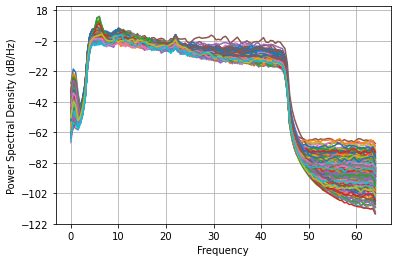

In [83]:
feature_vector = []
no_of_features = 164
feature = np.ones((40 , len(channel_no)*no_of_features + 10))
for video in range(0,40):
    print("Done: ", video)
    channel_count = 0
    for channel in channel_no:
        #-----------------------------------------------           Time-Domain Analysis      --------------------------------------------
        # 1.-------------------------------  Statistical parameters-------------------------------------------
        mean_result = np.mean(data[video,channel])
        var_result = np.var(data[video,channel])
        mode_result = float(st.mode(data[video,channel])[0])
        median_result = np.median(data[video,channel])
        skew_result = scipy.stats.skew(data[video,channel])
        std_result = np.std(data[video,channel])
        kurtosis_result = kurtosis(data[video,channel])
        f_d = first_difference(data[video,channel]) 
        normalised_first_difference = f_d/std_result
        s_d = second_difference(data[video,channel])
        normalised_second_difference = s_d/std_result
        
        # 2. Energy, Average Power, Root mean square value(RMS) 
        energy_value = energy(data[video,channel])
        avg_value = average_power(data[video,channel])
        rms_result = np.sqrt(np.mean(data[video,channel]**2))
        
        # 3. Katz fractal dimension (line length// curve length//total vertical length)
        katz_val = katz_fractal_dimension(data[video,channel])
        
        # 4. Nonlinear energy(NE)
        nle_val = non_linear_energy(data[video,channel])
        
        # 5. Shannon entropy (shEn)
        ShEn_result = shannon_entopy(data[video,channel])
        
        # 6. Approximate entropy
        entropy_value = ent.app_entropy(data[video,channel])
        
        # 7. Sample entropy
        sample_entropy = ent.sample_entropy(data[video,channel])
        
        # 8. Permutation entropy
        perm_entropy_val = ent.perm_entropy(data[video,channel], normalize=True)
        
        # 9. Weigheted Permutation Entropy 
        WPE = weighted_permutation_entropy(data[video,channel], order=3, normalize=False)

        # 10. Singular Value Decomposition 
        svd_entropy_val = ent.svd_entropy(data[video,channel], normalize=True) # Singular value decomposition entropy
        
        # 11. Hurst Exponent(HE)
        # Here we have two paramaters of HE i.e. H and c
        H, c, data_HC = compute_Hc(data[video,channel], kind='change', simplified=True)
        
        # 12. Fractal dimention
        higuchi_val = ent.higuchi_fd(data[video,channel])   # Higuchi fractal dimension
        petrosian_val = petrosian_fd(data[video,channel])   # Petrosian fractal dimension
        
        # 13. Hjorth mobility and complexity
        hjorth_avability, hjorth_mobilty, hjorth_complexity = ent.hjorth_params(data[video,channel])   # Hjorth mobility and complexity
        
        # 14. Detrended Fluctuation Analysis (DFA)
        DFA = ent.detrended_fluctuation(data[video,channel])
        
        # 15. Number of zero-crossings
        num_zerocross_val = ent.num_zerocross(data[video,channel])   # Number of zero-crossings
        
        # 16. Number of local extraimum
        local_extrema = extrema(data[video,channel])
        
        #--------------------------------------------------      Frequency Domain Analysis    ----------------------------
        # Power Spectral Density (PSD)
        psd,freqs = plt.psd(data[video,channel], Fs = 128)
        delta_low_freq, delta_high_freq = 0.5, 4
        theta_low_freq, theta_high_freq = 4, 8
        alpha_low_freq, alpha_high_freq = 8, 12
        beta_low_freq , beta_high_freq  = 12, 30
        gamma_low_freq , gamma_high_freq = 30, 48
        idx_delta = np.logical_and(freqs >= delta_low_freq, freqs <= delta_high_freq)
        idx_theta = np.logical_and(freqs >= theta_low_freq, freqs <= theta_high_freq)
        idx_alpha = np.logical_and(freqs >= alpha_low_freq, freqs <= alpha_high_freq)
        idx_beta  = np.logical_and(freqs >= beta_low_freq, freqs <= beta_high_freq)
        idx_gamma = np.logical_and(freqs >= gamma_low_freq, freqs <= gamma_high_freq)
        
        # Normalised psd
        #normalised_psd  = psd/energy(psd)
        
        # -------------------------   2. Energy, Average Power, Root mean square value(RMS) ---------------------
        # Energy calculation for each band
        delta_energy = energy(psd[idx_delta])
        theta_energy = energy(psd[idx_theta])
        alpha_energy = energy(psd[idx_alpha])
        beta_energy  = energy(psd[idx_beta])
        gamma_energy = energy(psd[idx_gamma])
        
        # Average power for each band
        delta_avg_power = average_power(psd[idx_delta])
        theta_avg_power = average_power(psd[idx_theta])
        alpha_avg_power = average_power(psd[idx_alpha])
        beta_avg_power  = average_power(psd[idx_beta])
        gamma_avg_power = average_power(psd[idx_gamma])
        
        # RMS value for each band
        delta_rms = np.sqrt(np.mean(psd[idx_delta]**2))
        theta_rms = np.sqrt(np.mean(psd[idx_theta]**2))
        alpha_rms = np.sqrt(np.mean(psd[idx_alpha]**2))
        beta_rms  = np.sqrt(np.mean(psd[idx_beta]**2))
        gamma_rms = np.sqrt(np.mean(psd[idx_gamma]**2))

        # 2. Intensity weighted mean frequency (IWMF)
        iwmf = IWMF(psd,freqs)
        
        # 3. Intensity weighted bandwidth (IWBW)
        iwbw = IWBW(psd,freqs)
        
        # 4. Spectral Edge Frequency applied after apllying Discrete Fourier Transform on the raw data
        sef = SpectralEdgeFreq(psd,freqs)
        
        # 5. Spectral Entropy
        spectral_entropy_val = ent.spectral_entropy(data[video,channel], sf=128, method='welch', normalize=True)  # Spectral entropy
        
        # 6. Peak Frequencies
        peaks, _ = find_peaks(psd, height = 0)
        peak_values = psd[peaks]
        avg_peak_value = np.mean(psd[peaks]) # main feature column
        
        # 7. Rational Asymmetry (RASM) and Differential Asymmetry (DASM) features
        # will be added at the last column of the feature vector
        if(channel < 16): # left
            delta_left =  delta_left + delta_avg_power
            theta_left =  theta_left + theta_avg_power
            alpha_left =  alpha_left + alpha_avg_power
            beta_left  =  beta_left  + beta_avg_power 
            gamma_left =  gamma_left + gamma_avg_power
            
        if(channel >=16):  # right
            delta_right = delta_right + delta_avg_power
            theta_right = theta_right + theta_avg_power
            alpha_right = alpha_right + alpha_avg_power
            beta_right  = beta_right  + beta_avg_power 
            gamma_right = gamma_right + gamma_avg_power
        #---------------------------------------------------     Wavelet feature extraction    ------------------------------------
        # discreate wavelet feature
        dwt_single = pywt.dwt(data[video,channel], 'db4') # single level decompositions
        CA = np.ravel(np.array(dwt_single[0]))
        CD = np.ravel(np.array(dwt_single[1]))
        # 1.1 statistical features are computed from the psd feature extraction
        # PSD calculation
        delta_mean_psd, delta_var_psd, delta_mode_psd, delta_median_psd, delta_skew_psd, delta_std_psd, delta_kurtosis_psd, delta_f_d_psd, delta_nfd_psd, delta_s_d_psd, delta_nsd_psd = sf_psd(psd[idx_delta])
        theta_mean_psd, theta_var_psd, theta_mode_psd, theta_median_psd, theta_skew_psd, theta_std_psd, theta_kurtosis_psd, theta_f_d_psd, theta_nfd_psd, theta_s_d_psd, theta_nsd_psd = sf_psd(psd[idx_theta])
        alpha_mean_psd, alpha_var_psd, alpha_mode_psd, alpha_median_psd, alpha_skew_psd, alpha_std_psd, alpha_kurtosis_psd, alpha_f_d_psd, alpha_nfd_psd, alpha_s_d_psd, alpha_nsd_psd = sf_psd(psd[idx_alpha]) 
        beta_mean_psd , beta_var_psd,  beta_mode_psd,  beta_median_psd,  beta_skew_psd,  beta_std_psd,  beta_kurtosis_psd,  beta_f_d_psd,  beta_nfd_psd,  beta_s_d_psd,  beta_nsd_psd  = sf_psd(psd[idx_beta]) 
        gamma_mean_psd, gamma_var_psd, gamma_mode_psd, gamma_median_psd, gamma_skew_psd, gamma_std_psd, gamma_kurtosis_psd, gamma_f_d_psd, gamma_nfd_psd, gamma_s_d_psd, gamma_nsd_psd = sf_psd(psd[idx_gamma])
        #-----------------------------------------------------------------------------------------------------------------------
        
        # 1.2 Statistical feature are computed from the DWT feature which is decomposed over 0-64 Hz data
        CA_mean_dwt, CA_var_dwt, CA_mode_dwt, CA_median_dwt, CA_skew_dwt, CA_std_dwt, CA_kurtosis_dwt, CA_f_d_dwt, CA_nfd_dwt, CA_s_d_dwt, CA_nsd_dwt = sf_dwt(CA)
        CD_mean_dwt, CD_var_dwt, CD_mode_dwt, CD_median_dwt, CD_skew_dwt, CD_std_dwt, CD_kurtosis_dwt, CD_f_d_dwt, CD_nfd_dwt, CD_s_d_dwt, CD_nsd_dwt = sf_dwt(CD)
        #----------------------------------------------------------------------------------------------------------------------
        
        # 2. Energy, Average Power  and RMS
        # Energy calculation for each band
        CA_energy = energy(CA)
        CD_energy = energy(CD)
        
        # Average power for each band
        CA_avg_power = average_power(CA)
        CD_avg_power = average_power(CD)
        
        # RMS value for each band
        CA_rms = np.sqrt(np.mean(CA**2))
        CD_rms = np.sqrt(np.mean(CD**2))
        
        # 3. shEn, ApEn , PE, WPE
        # 3.1 Shannon entropy (shEn)
        ShEn_CA = shannon_entopy(CA)
        ShEn_CD = shannon_entopy(CD)
        
        # 3.2 Approximate entropy
        entropy_CA = ent.app_entropy(CA)
        entropy_CD = ent.app_entropy(CD)
        
        # 3.3 Permutation entropy
        pe_CA = ent.perm_entropy(CA, normalize=True)
        pe_CD = ent.perm_entropy(CD, normalize=True)
        
        # 3.4 Weigheted Permutation Entropy 
        WPE_CA = weighted_permutation_entropy(CA, order=3, normalize=False)
        WPE_CD = weighted_permutation_entropy(CD, order=3, normalize=False)
        
        # 4. Hurst Exponent(HE)
            # Here we have two paramaters of HE i.e. H and c
        H_CA, c_CA, data_HC_CA = compute_Hc(CA, kind='change', simplified=True)
        H_CD, c_CD, data_HC_CD = compute_Hc(CD, kind='change', simplified=True)
        
        # 5. Fractal dimention
        higuchi_CA   = ent.higuchi_fd(CA)   # Higuchi fractal dimension
        petrosian_CA = petrosian_fd(CA)   # Petrosian fractal dimension
        higuchi_CD   = ent.higuchi_fd(CD)   # Higuchi fractal dimension
        petrosian_CD = petrosian_fd(CD)   # Petrosian fractal dimension
        
        # 6. Auto regressive (AR)
        res_CA = AutoReg(CA,lags = 128).fit()
        res_CD = AutoReg(CD,lags = 128).fit()
        aic_CA_ar  = res_CA.aic
        hqic_CA_ar = res_CA.hqic
        bic_CA_ar  = res_CA.bic
        llf_CA_ar  = res_CA.llf
        aic_CD_ar  = res_CD.aic
        hqic_CD_ar = res_CD.hqic
        bic_CD_ar  = res_CD.bic
        llf_CD_ar  = res_CD.llf
        
        # 7. Autoregressive moving Average (ARMA)
        arma_CA = stats.ARIMA(CA, order=(5,1,0)).fit()
        arma_CD = stats.ARIMA(CD, order=(3,1,0)).fit()
        aic_CA_arma  = arma_CA.aic
        hqic_CA_arma = arma_CA.hqic
        bic_CA_arma  = arma_CA.bic
        llf_CA_arma  = arma_CA.llf
        aic_CD_arma  = arma_CD.aic
        hqic_CD_arma = arma_CD.hqic
        bic_CD_arma  = arma_CD.bic
        llf_CD_arma  = arma_CD.llf
        #--------------------------------------------------------------------------------------------------------------------------
        feature_vector = [ mean_result, var_result, mode_result, median_result, skew_result, std_result, kurtosis_result, f_d,
                          normalised_first_difference, s_d, normalised_second_difference, energy_value, avg_value, rms_result,
                          katz_val, nle_val, ShEn_result, entropy_value, sample_entropy, perm_entropy_val, WPE, svd_entropy_val,
                          H, higuchi_val, petrosian_val, hjorth_avability, hjorth_mobilty, hjorth_complexity, DFA, num_zerocross_val,
                          local_extrema, delta_energy, theta_energy, alpha_energy, beta_energy, gamma_energy, delta_avg_power,
                          theta_avg_power, alpha_avg_power, beta_avg_power, gamma_avg_power, delta_rms, theta_rms, alpha_rms, beta_rms,
                          gamma_rms, iwmf, iwbw, sef, spectral_entropy_val, avg_peak_value, delta_mean_psd, delta_var_psd, delta_mode_psd,
                          delta_median_psd, delta_skew_psd, delta_std_psd, delta_kurtosis_psd, delta_f_d_psd, delta_nfd_psd, 
                          delta_s_d_psd, delta_nsd_psd , theta_mean_psd, theta_var_psd, theta_mode_psd, theta_median_psd, theta_skew_psd, 
                          theta_std_psd, theta_kurtosis_psd, theta_f_d_psd, theta_nfd_psd, theta_s_d_psd, theta_nsd_psd,
                          alpha_mean_psd, alpha_var_psd, alpha_mode_psd, alpha_median_psd, alpha_skew_psd, alpha_std_psd, alpha_kurtosis_psd,
                          alpha_f_d_psd, alpha_nfd_psd, alpha_s_d_psd, alpha_nsd_psd, beta_mean_psd , beta_var_psd,  beta_mode_psd,  
                          beta_median_psd,  beta_skew_psd,  beta_std_psd,  beta_kurtosis_psd,  beta_f_d_psd,  beta_nfd_psd,  beta_s_d_psd,
                          beta_nsd_psd, gamma_mean_psd, gamma_var_psd, gamma_mode_psd, gamma_median_psd, gamma_skew_psd, gamma_std_psd, 
                          gamma_kurtosis_psd, gamma_f_d_psd, gamma_nfd_psd, gamma_s_d_psd, gamma_nsd_psd, CA_mean_dwt, CA_var_dwt, 
                          CA_mode_dwt, CA_median_dwt, CA_skew_dwt, CA_std_dwt, CA_kurtosis_dwt, CA_f_d_dwt, CA_nfd_dwt, CA_s_d_dwt, CA_nsd_dwt, 
                          CD_mean_dwt, CD_var_dwt, CD_mode_dwt, CD_median_dwt, CD_skew_dwt, CD_std_dwt, CD_kurtosis_dwt, CD_f_d_dwt, CD_nfd_dwt,
                          CD_s_d_dwt, CD_nsd_dwt, CA_energy, CD_energy, CA_avg_power, CD_avg_power, CA_rms, CD_rms, ShEn_CA, ShEn_CD, entropy_CA,
                          entropy_CD, pe_CA, pe_CD, WPE_CA ,WPE_CD, H_CA, H_CD, higuchi_CA, petrosian_CA, higuchi_CD, petrosian_CD, aic_CA_ar, 
                          hqic_CA_ar, bic_CA_ar, llf_CA_ar, aic_CD_ar, hqic_CD_ar ,bic_CD_ar, llf_CD_ar, aic_CA_arma ,hqic_CA_arma,bic_CA_arma,
                          llf_CA_arma, aic_CD_arma, hqic_CD_arma, bic_CD_arma, llf_CD_arma]
        #feature_vector = np.concatenate((feature_vector,dwt_val))
        #print(type(feature_vector))
        #print(feature_vector[10])
        for i in range(0,164):
            #print(feature_vector[i],i)
            feature[video][channel_count + i] = feature_vector[i]
        channel_count = channel_count + 164
    
    delta_rasm = delta_left/delta_right
    theta_rasm = theta_left/theta_right
    alpha_rasm = alpha_left/alpha_right
    beta_rasm  = beta_left/beta_right
    gamma_rasm = gamma_left/gamma_right
    
    delta_dasm = delta_left - delta_right
    theta_dasm = theta_left - theta_right
    alpha_dasm = alpha_left - alpha_right
    beta_dasm  = beta_left  - beta_right
    gamma_dasm = gamma_left - gamma_right
    fv = [delta_rasm, theta_rasm, alpha_rasm, beta_rasm, gamma_rasm, delta_dasm, theta_dasm, alpha_dasm, beta_dasm, gamma_dasm]
    c_draft = 0
    for i in range(feature.shape[1] - len(fv), feature.shape[1]):
      feature[video][i] = fv[c_draft]
      c_draft = c_draft + 1

In [89]:
channels = ['mean_result', 'var_result', 'mode_result', 'median_result', 'skew_result', 'std_result', 'kurtosis_result', 'f_d', 
 'normalised_first_difference', 's_d', 'normalised_second_difference', 'energy_value', 'avg_value', 'rms_result',
'katz_val', 'nle_val', 'ShEn_result', 'entropy_value', 'sample_entropy', 'perm_entropy_val', 'WPE', 'svd_entropy_val',
'H', 'higuchi_val', 'petrosian_val', 'hjorth_avability', 'hjorth_mobilty', 'hjorth_complexity', 'DFA', 'num_zerocross_val',
'local_extrema', 'delta_energy', 'theta_energy', 'alpha_energy', 'beta_energy', 'gamma_energy', 'delta_avg_power',
'theta_avg_power', 'alpha_avg_power', 'beta_avg_power', 'gamma_avg_power', 'delta_rms', 'theta_rms', 'alpha_rms', 'beta_rms',
'gamma_rms', 'iwmf', 'iwbw', 'sef', 'spectral_entropy_val', 'avg_peak_value', 'delta_mean_psd', 'delta_var_psd', 'delta_mode_psd',
'delta_median_psd', 'delta_skew_psd', 'delta_std_psd', 'delta_kurtosis_psd', 'delta_f_d_psd', 'delta_nfd_psd', 
'delta_s_d_psd', 'delta_nsd_psd', 'theta_mean_psd', 'theta_var_psd', 'theta_mode_psd', 'theta_median_psd', 'theta_skew_psd', 
'theta_std_psd', 'theta_kurtosis_psd', 'theta_f_d_psd', 'theta_nfd_psd', 'theta_s_d_psd', 'theta_nsd_psd',
'alpha_mean_psd', 'alpha_var_psd', 'alpha_mode_psd', 'alpha_median_psd', 'alpha_skew_psd', 'alpha_std_psd', 'alpha_kurtosis_psd',
'alpha_f_d_psd', 'alpha_nfd_psd', 'alpha_s_d_psd', 'alpha_nsd_psd', 'beta_mean_psd', 'beta_var_psd', 'beta_mode_psd',  
'beta_median_psd', 'beta_skew_psd', 'beta_std_psd', 'beta_kurtosis_psd', 'beta_f_d_psd', 'beta_nfd_psd', 'beta_s_d_psd',
'beta_nsd_psd', 'gamma_mean_psd', 'gamma_var_psd', 'gamma_mode_psd', 'gamma_median_psd', 'gamma_skew_psd', 'gamma_std_psd', 
'gamma_kurtosis_psd', 'gamma_f_d_psd', 'gamma_nfd_psd', 'gamma_s_d_psd', 'gamma_nsd_psd', 'CA_mean_dwt', 'CA_var_dwt', 
 'CA_mode_dwt', 'CA_median_dwt', 'CA_skew_dwt', 'CA_std_dwt', 'CA_kurtosis_dwt', 'CA_f_d_dwt', 'CA_nfd_dwt', 'CA_s_d_dwt', 'CA_nsd_dwt', 
'CD_mean_dwt', 'CD_var_dwt', 'CD_mode_dwt', 'CD_median_dwt', 'CD_skew_dwt', 'CD_std_dwt', 'CD_kurtosis_dwt', 'CD_f_d_dwt', 'CD_nfd_dwt',
'CD_s_d_dwt', 'CD_nsd_dwt', 'CA_energy', 'CD_energy', 'CA_avg_power', 'CD_avg_power', 'CA_rms', 'CD_rms', 'ShEn_CA', 'ShEn_CD', 'entropy_CA',
'entropy_CD', 'pe_CA', 'pe_CD', 'WPE_CA', 'WPE_CD', 'H_CA', 'H_CD', 'higuchi_CA', 'petrosian_CA', 'higuchi_CD', 'petrosian_CD', 'aic_CA_ar', 
'hqic_CA_ar', 'bic_CA_ar', 'llf_CA_ar', 'aic_CD_ar', 'hqic_CD_ar', 'bic_CD_ar', 'llf_CD_ar', 'aic_CA_arma', 'hqic_CA_arma', 'bic_CA_arma',
'llf_CA_arma', 'aic_CD_arma', 'hqic_CD_arma', 'bic_CD_arma', 'llf_CD_arma']

In [98]:
channels_name = []
for i in eeg_channels[channel_no]:
  for j in channels:
    channels_name.append(i+ "_" + j)
draft_name = ['delta_rasm', 'theta_rasm', 'alpha_rasm', 'beta_rasm', 'gamma_rasm', 'delta_dasm', 'theta_dasm', 'alpha_dasm', 'beta_dasm', 'gamma_dasm']
for i in draft_name:
  channels_name.append(i)

In [99]:
subject = "s01"
df = pd.DataFrame(feature, columns = channels_name)
mypath = "/content/drive/MyDrive/Sequential methods for channel selection/our code/" + subject + "/" + subject + "_hybrid.csv"
df.to_csv(mypath, index = False, encoding = 'utf-8-sig')

In [1]:
subject_arousal_channels = [['P7', 'CP1', 'P3', 'Fz', 'P8', 'FC2', 'Cz'], ['FC2', 'P7', 'AF4', 'FC6', 'AF3', 'F4', 'O1'],
                            ['AF4', 'FC1', 'O2', 'F3', 'AF3', 'P8', 'T7', 'C4', 'Pz', 'FC5', 'PO3'], ['P8', 'CP2', 'P7', 'Pz', 'P3'], ['Fz', 'P7', 'T7', 'CP6', 'O2', 'Fp1'], 
                            ['C3', 'AF4', 'AF3', 'P7', 'F3', 'F4', 'CP5', 'T8', 'Oz', 'FC6', 'F7', 'Cz'], ['FC1', 'F3', 'O1', 'FC5', 'P3', 'Fz'], ['T8', 'Fp1', 'FC6', 'Fp2', 'Fz', 'CP2', 'PO3', 'CP1', 'Cz'], ['AF4'],
                            ['FC1', 'Fp1', 'CP5', 'P7', 'T8', 'PO4', 'C3', 'PO3', 'F4', 'Cz', 'Fp2'], ['T7'], ['FC6', 'CP5', 'F3', 'Cz', 'FC2'],
                            ['PO3', 'P7', 'Fp2'], ['PO3', 'FC2', 'P3', 'AF3', 'CP5', 'Pz', 'F7', 'T7', 'O2', 'F3'],
                            ['FC2', 'FC1', 'Fz', 'P3', 'AF4', 'Cz', 'CP1', 'CP2', 'Fp2', 'AF3', 'CP5', 'Pz'], ['O2', 'FC1', 'C3', 'C4', 'Fp1'],
                            ['P4', 'CP2', 'FC2', 'Fp1'], ['AF4', 'FC6', 'FC5', 'PO4', 'P3', 'CP1'], ['CP5', 'P8', 'C4', 'FC6', 'PO4', 'O2', 'P4', 'CP6', 'P7', 'CP2', 'PO3', 'FC2'],
                            ['F3', 'P7', 'CP6', 'F4', 'FC6', 'Fz', 'T7', 'FC5', 'PO3', 'Cz', 'O2'], ['P4', 'Fz'], ['O1', 'CP2', 'FC1', 'CP1', 'T8', 'F8', 'P8'], ['Fp1', 'F3', 'CP5', 'Cz', 'FC5'],
                            ['Pz', 'O2', 'P8', 'CP2', 'O1', 'PO3', 'F8', 'FC1', 'P3', 'CP1', 'Cz', 'T8', 'FC2', 'C3', 'FC5', 'Fz', 'CP5', 'F4', 'PO4', 'F7', 'Oz', 'T7', 'P7', 'AF4', 'Fp2', 'FC6', 'F3', 'P4', 'Fp1', 'AF3', 'C4', 'CP6'],
                            ['FC2'], ['AF4', 'FC5', 'CP5', 'Oz', 'FC2', 'FC1', 'C3', 'CP6', 'T7', 'F3', 'Cz', 'AF3', 'P4'], ['PO3', 'Oz', 'AF4', 'CP6', 'F8', 'Cz', 'FC6', 'O1', 'P8', 'F4', 'Fp2'],
                            ['PO3', 'F4', 'FC6', 'Oz', 'CP2', 'O2', 'P4', 'CP6'], ['O2', 'CP6', 'Cz', 'PO4', 'O1', 'FC1', 'T8', 'P4', 'F4', 'C3'],
                            ['Oz', 'P4', 'CP1', 'P3', 'FC6', 'AF3', 'F3', 'F7', 'CP2', 'Cz', 'CP5', 'C4', 'FC1', 'P8', 'T8', 'T7', 'F8', 'C3', 'O2', 'CP6', 'Fp1', 'AF4', 'O1', 'F4'],
                            ['FC2', 'C4', 'PO4', 'P4', 'F4', 'FC1', 'C3', 'CP6', 'AF3', 'T7'], ['Fz', 'Cz', 'P7', 'F4', 'F8', 'C4', 'P4']]

In [102]:
subject_valence_channels = [['Fz', 'FC2', 'CP6', 'F7', 'FC1'],
['AF3', 'F7', 'F4', 'AF4', 'CP1', 'O1', 'FC6', 'CP2', 'F8', 'T7', 'FC2', 'Fp1', 'P3', 'CP6', 'Fp2', 'Cz'],
['O2', 'Oz', 'FC1'],
['O2', 'CP1', 'PO3'],
['C4', 'Cz', 'CP6', 'P7', 'FC6', 'FC2', 'O2', 'F4', 'F7', 'F3', 'Fp1', 'AF3', 'PO3', 'T7', 'AF4'],
['P4', 'FC6', 'CP2', 'F4', 'O1', 'O2', 'Oz', 'Cz'],
['PO4', 'P4', 'T7', 'FC6', 'F4', 'FC5', 'F7', 'AF3'],
['Fp1', 'P8', 'CP6', 'P7', 'AF3', 'O2', 'C4', 'Pz', 'T8', 'FC2', 'P3', 'AF4', 'PO3', 'Cz', 'CP5', 'Fz'],
['AF4', 'Oz', 'C4', 'F4'],
['P3', 'CP6', 'FC6'],
['P4', 'F4', 'P7', 'FC2'],
['CP1', 'F4', 'F3'],
['Cz', 'Fp2', 'Pz', 'AF3', 'FC2', 'P4', 'F7'],
['FC2', 'P3', 'F8', 'P8', 'FC5', 'AF4'],
['Pz', 'AF3'],
['FC6', 'Fp1', 'Fp2', 'Cz', 'P4', 'P3', 'PO3', 'Oz', 'C4', 'CP2', 'F3', 'CP1', 'O1', 'P8', 'T8', 'C3', 'PO4', 'Pz', 'Fz', 'F8', 'FC2', 'CP6', 'F4', 'P7'],
['F8', 'P3', 'PO3', 'C3'],
['FC6', 'AF4', 'FC1', 'Pz', 'Oz', 'C3', 'F8', 'CP1', 'T7', 'Cz', 'PO4', 'T8', 'Fp1'],
['C4', 'F3', 'CP6', 'FC6', 'CP1'],
['AF4'],
['AF3', 'P3', 'F4', 'PO4', 'Oz', 'CP2', 'AF4', 'T8'],
['C3', 'PO4', 'P4', 'PO3', 'Fp2', 'AF4', 'C4', 'Fz', 'F3', 'Fp1', 'F4', 'AF3', 'CP5', 'FC2', 'FC5', 'FC1', 'Oz'],
['T8', 'P4', 'F4', 'AF3'],
['FC1', 'Pz', 'F7'],
['FC2', 'Fp2'],
['Pz', 'P3', 'FC2', 'P7', 'T7'],
['Oz', 'FC5', 'CP6', 'O2', 'C4', 'CP2', 'FC6', 'F3', 'C3', 'P3', 'CP5', 'P4', 'PO4', 'Cz', 'FC1', 'Pz', 'O1', 'Fz', 'T7', 'FC2', 'P7', 'Fp2'],
['C3', 'CP2', 'F3', 'O1', 'CP1', 'Pz', 'Oz', 'PO4', 'O2', 'P4', 'Fz', 'P8'],
['AF3', 'Cz', 'CP6', 'P4', 'Fp1', 'F8', 'F3', 'P7', 'FC6', 'F4', 'AF4'],
['PO4', 'Fz', 'Cz', 'AF3', 'FC2', 'Oz', 'P4', 'FC1', 'Fp2', 'O1', 'O2', 'Fp1', 'C3', 'T7'],
['CP6', 'CP2', 'Cz', 'CP5'],
['CP2', 'O1', 'O2', 'CP6', 'CP5', 'PO4', 'FC5', 'P8', 'P4', 'T7', 'FC1', 'C4', 'F3', 'Fp1']]